In [15]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [16]:
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from torchaudio.transforms import Spectrogram, AmplitudeToDB

# torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
torchaudio.set_audio_backend('sox_io')
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
import psutil
import requests

from utils import *
from wingbeat_datasets import *
from wingbeat_models import *

# print(f'Total RAM      : {bytes2GB(psutil.virtual_memory().total):5.2f} GB')
# print(f'Available RAM  : {bytes2GB(psutil.virtual_memory().available):5.2f} GB\n')

In [47]:
num_epochs = 3
batch_size = 32
batch_size_val = batch_size * 2
validation_split = .2
shuffle_dataset = True
num_workers = psutil.cpu_count()
random_seed= 42
setting = 'stft'# 'stft', 'reassigned_stft', 'melstft'
modelname = 'densenet121' # 'resnet34','resnet152'

## Datasets and Dataloaders

In [48]:
transforms_list = [FilterWingbeat(setting='bandpass'), TransformWingbeat(setting=setting)]
# [FilterWingbeat(setting='bandpass'), NormalizeWingbeat(), TransformWingbeat(setting=setting)]

dmel1 = WingbeatsDataset(dsname="Melanogaster_RL/Z", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
dmel2 = WingbeatsDataset(dsname="Melanogaster_RL/Y", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
dsuz1 = WingbeatsDataset(dsname="Suzukii_RL/Y",      custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))
dsuz2 = WingbeatsDataset(dsname="Suzukii_RL/X",      custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))
transformed_dataset = ConcatDataset([dmel1, dsuz1])

train_size = int(0.8 * len(transformed_dataset))
valid_size = len(transformed_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(transformed_dataset, [train_size, valid_size])
test_dataset = ConcatDataset([dmel2, dsuz2])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)
plt.imshow(train_dataset[5][0][0])

Found 12150 in dataset: Melanogaster_RL/Z, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Found 12003 in dataset: Melanogaster_RL/Y, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Found 18166 in dataset: Suzukii_RL/Y, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]
Found 14703 in dataset: Suzukii_RL/X, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]


TypeError: 'NoneType' object is not subscriptable

## Model definition

In [22]:
from torchvision.models import resnet34, densenet121, resnet152
import torch.optim as optim

if setting in ['stft', 'reassigned_stft', 'melstft']:
    if modelname == 'densenet121':
        model = densenet121(pretrained=False)
        num_ftrs = model.classifier.in_features
        model.fc = nn.Linear(num_ftrs,2)
    elif modelname in ['resnet34', 'resnet152']:
        model = densenet121(pretrained=False)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs,2)        

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
early_stopping = EarlyStopping(patience=7, verbose=2, path=f'data_created/{setting}_{modelname}_melZY_suzYX.pt')
# print(model)

## Training

In [23]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

import warnings
warnings.filterwarnings("ignore")

# Model training
for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    model.train()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(train_dataloader, desc='Training..\t'):        

        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
        
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()

    train_accuracy = correct_train / (len(train_dataloader)*batch_size) * 100.
    # Going through the validation set
    correct_valid = 0
    model.eval()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(valid_dataloader, desc='Validating..\t'):
        
        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()

        pred = model(x_batch)
        val_loss = criterion(pred, y_batch)
        correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
    valid_accuracy = correct_valid / (len(valid_dataloader)*batch_size_val) * 100.
    scheduler.step(val_loss)
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

        # Printing results
    print(f"Epoch {epoch}: train_acc: {train_accuracy:.2f}% loss: {loss:.3f},  val_loss: {val_loss:.3f} val_acc: {valid_accuracy:.2f}%")

correct_test = 0
model.eval()
for x_batch,y_batch,path_batch,idx_batch in tqdm(test_dataloader, desc="Testing..\t"):

    y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
    x_batch,y_batch = x_batch.cuda(), y_batch.cuda()

    pred = model(x_batch)
    val_loss = criterion(pred, y_batch)
    correct_test += (pred.argmax(axis=1) == y_batch).float().sum().item()
test_accuracy = correct_test / (len(test_dataloader)*batch_size_val) * 100.
print(test_accuracy)

Train on gpu: True


In [59]:
num_epochs = 3
batch_size = 32
batch_size_val = batch_size * 2
validation_split = .2
shuffle_dataset = True
num_workers = psutil.cpu_count()
random_seed= 42
setting = 'raw'
modeltype = 'wingbeatraw'
normalize = ""#"sample"

Found 12150 in dataset: Melanogaster_RL/Z, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Found 12003 in dataset: Melanogaster_RL/Y, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Found 18166 in dataset: Suzukii_RL/Y, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]
Found 14703 in dataset: Suzukii_RL/X, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]


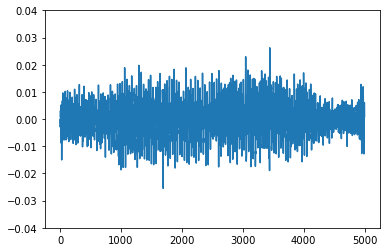

In [60]:
transforms_list = [FilterWingbeat(setting='bandpass')]

if normalize == "whole":
    dmel1 = WingbeatsDataset(dsname="Melanogaster_RL/Y", clean=True,transform=transforms.Compose(transforms_list))
    dsuz1 = WingbeatsDataset(dsname="Suzukii_RL/L", clean=True, transform=transforms.Compose(transforms_list))
    transformed_dataset = ConcatDataset([dmel1, dsuz1])
    trainval_dataloader = DataLoader(transformed_dataset, batch_size=batch_size, num_workers=num_workers)

    mean, std = calc_mean_std_1D(loader=trainval_dataloader)
    transforms_list += [Normalize(mean=mean, std=std, axes=(0,2))]
elif normalize == "sample":
    transforms_list += [Normalize()]
else:
    pass

dmel1 = WingbeatsDataset(dsname="Melanogaster_RL/Z", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
dmel2 = WingbeatsDataset(dsname="Melanogaster_RL/Y", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
dsuz1 = WingbeatsDataset(dsname="Suzukii_RL/Y",      custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))
dsuz2 = WingbeatsDataset(dsname="Suzukii_RL/X",      custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))

transformed_dataset = ConcatDataset([dmel1, dsuz1])
trainval_dataloader = DataLoader(transformed_dataset, batch_size=batch_size, num_workers=num_workers)
train_size = int(0.8 * len(transformed_dataset))
valid_size = len(transformed_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(transformed_dataset, [train_size, valid_size])
test_dataset = ConcatDataset([dmel2, dsuz2])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)
from IPython.display import Audio
sig = train_dataset[6][0]
plt.plot(sig.T); plt.ylim(-.04,.04)
Audio(sig, rate=8000, autoplay=True)

In [61]:
if setting.startswith('psd'):
    model = DrosophilaNetPSD()
elif modeltype == 'wingbeatraw':
    model = DrosophilaNetRAW()
elif modeltype == 'inception':
    model = nn.Sequential(
                    InceptionBlock(
                        in_channels=1, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    InceptionBlock(
                        in_channels=32*4, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.AdaptiveAvgPool1d(output_size=1),
                    Flatten(out_features=32*4*1),
                    nn.Linear(in_features=4*32*1, out_features=2))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
early_stopping = EarlyStopping(patience=7, verbose=1, path=f'data_created/{setting}_{modelname}_melZY_suzYX.pt')
# print(model)

## Training

In [62]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

# Model training
for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    model.train()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(train_dataloader, desc='Training..\t'):        

        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
        
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()

    train_accuracy = correct_train / (len(train_dataloader)*batch_size) * 100.
    # Going through the validation set
    correct_valid = 0
    model.eval()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(valid_dataloader, desc='Validating..\t'):
        
        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()

        pred = model(x_batch)
        val_loss = criterion(pred, y_batch)
        correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
    valid_accuracy = correct_valid / (len(valid_dataloader)*batch_size_val) * 100.
    scheduler.step(val_loss)
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

        # Printing results
    print(f"Epoch {epoch}: train_acc: {train_accuracy:.2f}% loss: {loss:.3f},  val_loss: {val_loss:.3f} val_acc: {valid_accuracy:.2f}%")


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Train on gpu: True


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (inf --> 1.330543).  Saving model ...
Epoch 0: train_acc: 89.33% loss: 0.091,  val_loss: 1.331 val_acc: 56.68%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 1: train_acc: 93.00% loss: 0.087,  val_loss: 5.073 val_acc: 40.81%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 80.80it/s] 

Epoch 2: train_acc: 93.95% loss: 0.097,  val_loss: 4.321 val_acc: 41.53%


In [63]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)
test_dataset = ConcatDataset([dmel2, dsuz2])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

def test(model, loader):
    correct_test = 0
    model.eval()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(loader, desc='Testing..\t'):

        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()

        pred = model(x_batch)
        val_loss = criterion(pred, y_batch)
        correct_test += (pred.argmax(axis=1) == y_batch).float().sum().item()
    test_accuracy = correct_test / (len(test_dataloader)*batch_size_val) * 100.
    print(test_accuracy)
test(model,test_dataloader)

Testing..	:   0%|          | 0/418 [00:00<?, ?it/s]

Train on gpu: True


Testing..	: 100%|██████████| 418/418 [00:03<00:00, 115.26it/s]

45.772278708133975


In [64]:
from torchcam.cams import CAM

In [65]:
from PIL import Image
from torchvision.transforms.functional import normalize, resize, to_tensor, to_pil_image
from torchcam.utils import overlay_mask


In [66]:
dmodel = model

In [164]:
submodule_dict = dict(dmodel.named_modules())

In [165]:
locate_linear_layer(dmodel)

'fc1'

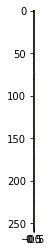

In [166]:
fc_layer = submodule_dict['fc1']
fc_weights = submodule_dict['fc1'].weight.data
cam = CAM(dmodel, 'avgPool', 'fc1')

with torch.no_grad():
    out = dmodel(torch.from_numpy(np.expand_dims(dmel1[0][0], axis=0)).cuda())
    
z = cam(class_idx=1)
z.shape

plt.imshow(z.cpu().numpy())

In [168]:
# z

torch.Size([256, 1])

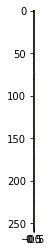

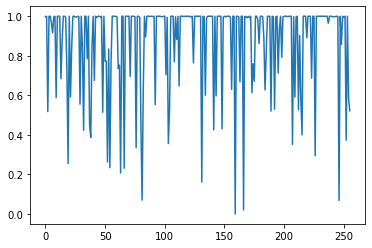

In [119]:
plt.plot(z.cpu().numpy())

In [120]:
z.cpu().numpy().shape

(256, 1)

In [179]:
from torchvision.models import resnet18
from torchcam.cams import CAM
model = resnet18(pretrained=True).eval()
cam = CAM(model, 'layer4', 'fc')
input_tensor = torch.from_numpy(np.random.randn(1,3,224,224)).float()
with torch.no_grad(): scores = model(input_tensor)

In [180]:
cam._hooks_enabled = True

In [181]:
model.zero_grad()

In [182]:
activation_map = cam(class_idx=100, scores=out)

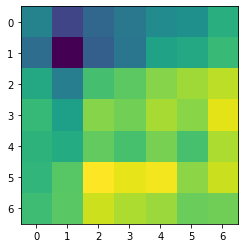

In [183]:
plt.imshow(activation_map)

In [184]:
cam.clear_hooks()
cam._hooks_enabled = False

In [185]:
heatmap = to_pil_image(activation_map, mode='F')

In [190]:
new_p = Image.fromarray(np.array(heatmap))
if new_p.mode != 'RGB':
    new_p = new_p.convert('RGB')
new_p

In [194]:
overlay_mask(Image.fromarray(input_tensor.float().numpy().squeeze()) ,new_p)

TypeError: Cannot handle this data type: (1, 1, 224), <f4

In [193]:
input_tensor.float().numpy().shape

(1, 3, 224, 224)

In [162]:
dmodel

Conv1dNetRAW(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv1d(128, 256, kernel_size=(3,), stride=(1,)

In [123]:
submodule_dict = dict(model.named_modules())

In [134]:
from torchsummary import summary
model = model.to('cuda', dtype=torch.float)


In [135]:
summary(model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [67]:
# dmodel.features.denseblock4.denselayer16.conv2
extractor = CAM(dmodel, 'features', 'classifier')

extractor._hooks_enabled = False
idx = 1
extractor._hooks_enabled = True
dmodel.zero_grad()

i = 21600
sig = train_dataset[i][0].numpy()

sig = np.moveaxis(sig, 0, -1)#.shape

from PIL import Image
pil_img = Image.fromarray(sig.astype(np.uint8))

scores = dmodel(train_dataset[i][0].unsqueeze(0).to(device='cuda'))
class_idx = 0 #scores.squeeze(0).argmax().item() if args.class_idx is None else args.class_idx

# Use the hooked data to compute activation map
activation_map = extractor(class_idx, scores).cpu()

# Clean data
extractor.clear_hooks()
extractor._hooks_enabled = False
# Convert it to PIL image
# The indexing below means first image in batch
heatmap = to_pil_image(activation_map, mode='F')
# Plot the result
result = overlay_mask(pil_img, heatmap)

plt.imshow(result)


ValueError: Unable to find submodule features in the model

In [42]:
extractor._get_weights(class_idx, scores)

tensor([0.0904, 0.0234, 0.0746,  ..., 0.0857, 0.0749, 0.0823], device='cuda:0')

In [43]:
extractor(class_idx, scores).cpu()

tensor([[1.0000, 0.4715, 0.1592],
        [0.0198, 0.0000, 0.0147],
        [0.1106, 0.1661, 0.0278],
        [0.5891, 0.1979, 0.0832]])

In [44]:
np.array(to_pil_image(activation_map, mode='F'))

array([[1.        , 0.47150204, 0.15924002],
       [0.01981649, 0.        , 0.01466209],
       [0.110572  , 0.16608258, 0.02778095],
       [0.58906263, 0.19793193, 0.08322237]], dtype=float32)

In [45]:
scores

tensor([[  4.9193,  21.1196, -34.5184, -30.3399, -31.7354, -32.2826, -31.0275,
         -31.7701, -32.0444, -30.3498, -30.8187, -32.6558, -30.7483, -32.3830,
         -31.4920, -30.9372, -31.1872, -32.2130, -32.3830, -32.5334, -30.2837,
         -31.8698, -32.9458, -31.4479, -32.2566, -31.9666, -31.9589, -31.9754,
         -32.1911, -31.7015, -31.2342, -30.9143, -31.0538, -31.6976, -32.4750,
         -31.5355, -31.3371, -32.0217, -31.5578, -31.7144, -31.4491, -31.1477,
         -31.9661, -31.4754, -32.7703, -32.4528, -31.1979, -31.7406, -31.8033,
         -32.2399, -30.8804, -32.3391, -31.2313, -30.9442, -31.4948, -32.0966,
         -32.5105, -32.8625, -31.6262, -31.5330, -32.5766, -32.4860, -31.7021,
         -31.7586, -31.8965, -32.5752, -30.6580, -33.0337, -33.3467, -32.1025,
         -33.2925, -32.2856, -30.4291, -31.0327, -32.7031, -30.9577, -32.9343,
         -32.1762, -31.3644, -31.4740, -30.5822, -31.8139, -31.8437, -32.1417,
         -31.6595, -31.8381, -31.3300, -32.0934, -32

In [79]:
# for name, layer in model.named_modules():
# ...     if isinstance(layer, torch.nn.Conv2d):
# ...             print(name, layer)